In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_30/1398053902.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


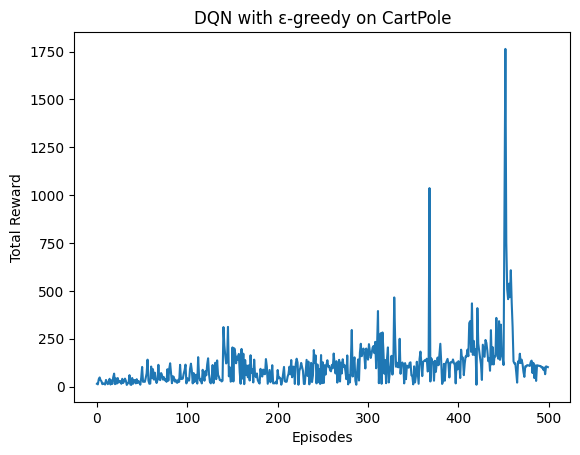

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

episodes = 5000
gamma = 0.99
learning_rate = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
memory_size = 10000
target_update = 10

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)
rewards_list = []

def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state)).argmax().item()

def optimize_model():
    if len(memory) < batch_size:
        return
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    current_q = policy_net(states).gather(1, actions)
    max_next_q = target_net(next_states).max(1)[0]
    expected_q = rewards + (gamma * max_next_q * (1 - dones))

    loss = nn.MSELoss()(current_q, expected_q.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        optimize_model()
    rewards_list.append(total_reward)
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

plt.plot(rewards_list)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("DQN with ε-greedy on CartPole")
plt.show()


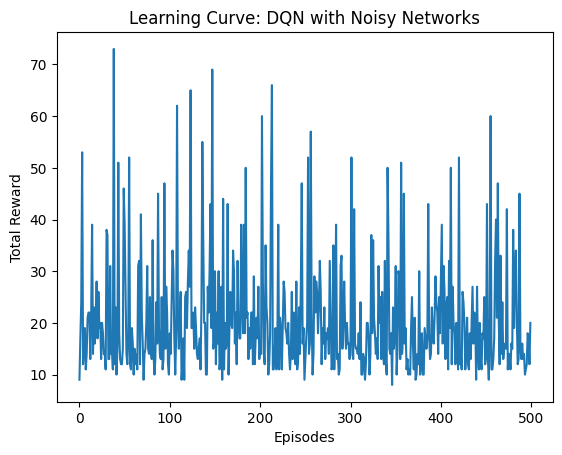

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer("weight_epsilon", torch.FloatTensor(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer("bias_epsilon", torch.FloatTensor(out_features))
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())

    def forward(self, x):
        if self.training:
            return F.linear(x, self.weight_mu + self.weight_sigma * self.weight_epsilon,
                            self.bias_mu + self.bias_sigma * self.bias_epsilon)
        else:
            return F.linear(x, self.weight_mu, self.bias_mu)

class NoisyDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NoisyDQN, self).__init__()
        self.fc1 = NoisyLinear(state_dim, 24)
        self.fc2 = NoisyLinear(24, 24)
        self.fc3 = NoisyLinear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

    def reset_noise(self):
        self.fc1.reset_noise()
        self.fc2.reset_noise()
        self.fc3.reset_noise()

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = NoisyDQN(state_dim, action_dim)
target_net = NoisyDQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
episodes = 5000
win_rate, draw_rate, lose_rate = 0, 0, 0
rewards_list = []

for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        action = policy_net(torch.FloatTensor(state)).argmax().item()
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        
        # Track win, draw, lose outcomes
        if done:
            if total_reward >= 500:
                win_rate += 1
            elif total_reward >= 400:
                draw_rate += 1
            else:
                lose_rate += 1
        
        state = next_state
        policy_net.reset_noise() 

    rewards_list.append(total_reward)
    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

plt.plot(rewards_list)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve: DQN with Noisy Networks")
plt.show()


